# Manifold reconstruction of monkey (V1) LFP

In [1]:
import numpy as np
import mne
import os
import pywt
import scipy.io as sio
from scipy import signal
from scipy.signal import hilbert
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.stattools import acf
from scipy.ndimage import gaussian_filter1d


from stochastic_dynamics.models import AR, TAR
from stochastic_dynamics.embedders import embed
from stochastic_dynamics.pub_utils import *

# capture future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

set_pub_style()

In [ ]:
# Data loading functions

def load_lfp_data(data_dir, file_names):
    data = [sio.loadmat(os.path.join(data_dir, fn)) for fn in file_names]
    
    LFP, Loc_X, Loc_Y, Elec_ID, Array_ID = [], [], [], [], []
    for d in data:
        LFP.append(d['lfp'])
        Loc_X.append(d['schematic_X_position'])
        Loc_Y.append(d['schematic_Y_position'])
        Elec_ID.append(d['Electrode_ID'])
        Array_ID.append(d['Array_ID'])
    
    return (np.concatenate(LFP, axis=1), np.concatenate(Loc_X), 
            np.concatenate(Loc_Y), np.concatenate(Elec_ID), np.concatenate(Array_ID))

def preprocess_channel(lfp_data, time_window, chan, Fs):
    filtered = signal.filtfilt(*signal.iirnotch(50, 30, Fs), lfp_data[time_window, chan])
    cfs, freqs = pywt.cwt(filtered, scales=np.arange(1, 129), wavelet='cmor', sampling_period=1/Fs)
    power = np.mean(np.abs(cfs)**2, axis=1)
    return filtered, power

def bandpass_filter(x, Fs, low, high, order=4):
    wn = [low/(Fs/2), high/(Fs/2)]
    sos = signal.butter(order, wn, btype='bandpass', output='sos')
    return signal.sosfiltfilt(sos, x)

# Load data
data_dir = '/home/rudra/Documents/StocasticDiffEq_Simulation/notebooks/data'
file_names = ['NSP1_array1_LFP.mat', 'NSP1_array2_LFP.mat', 'NSP2_array3_LFP.mat', 'NSP2_array4_LFP.mat', 
              'NSP3_array5_LFP.mat', 'NSP3_array6_LFP.mat', 'NSP4_array7_LFP.mat', 'NSP4_array8_LFP.mat', 
              'NSP5_array9_LFP.mat', 'NSP5_array10_LFP.mat', 'NSP6_array11_LFP.mat', 'NSP6_array12_LFP.mat', 
              'NSP7_array13_LFP.mat', 'NSP7_array14_LFP.mat', 'NSP8_array15_LFP.mat', 'NSP8_array16_LFP.mat']

Fs = 500
LFP, Loc_X, Loc_Y, Elec_ID, Array_ID = load_lfp_data(data_dir, file_names)
Time = np.arange(LFP.shape[0]) / Fs

V4_chan = np.where((Array_ID == 2) | (Array_ID == 3))[0]
V1_chan = np.where((Array_ID != 2) & (Array_ID != 3))[0]

# Process single channel
time_window = np.arange(10000)
chan = 1001
filtered_LFP, power = preprocess_channel(LFP, time_window, chan, Fs)

# Prepare signal
x = np.asarray(filtered_LFP).ravel()
T = len(x)
time = np.arange(T) / Fs

# Apply bandpass filter
x_lp = bandpass_filter(x, Fs, low=4.0, high=12.0)

snippet_sec = 5.0
N = int(snippet_sec * Fs)
t_snip = time[:N]
x_snip = x_lp[:N]

Processing channel 1002


In [3]:
# Signal processing utility functions

def notch_iir(y, Fs, freqs=(60.0, 120.0), Q=30.0):
    z = y.astype(float)
    for f0 in freqs:
        if f0 < Fs/2:
            b, a = signal.iirnotch(f0, Q, Fs)
            z = signal.filtfilt(b, a, z)
    return z

def butter_filter(y, Fs, hp=None, lp=None, order=4):
    ny = Fs/2
    if hp and lp:
        b, a = signal.butter(order, [hp/ny, lp/ny], btype='band')
    elif hp:
        b, a = signal.butter(order, hp/ny, btype='high')
    elif lp:
        b, a = signal.butter(order, lp/ny, btype='low')
    else:
        return y
    return signal.filtfilt(b, a, y, method='gust')

def envelope_normalize(x, fs, fband=(15, 30), env_lp_hz=5.0, eps=1e-6):
    b, a = signal.butter(4, np.array(fband)/(fs/2), btype='bandpass')
    x_bp = signal.filtfilt(b, a, x)
    z = hilbert(x_bp)
    A = np.abs(z)
    if env_lp_hz is not None:
        b_lp, a_lp = signal.butter(2, env_lp_hz/(fs/2), btype='low')
        A = signal.filtfilt(b_lp, a_lp, A)
    x_flat = x_bp / (A + eps)
    x_flat *= np.median(A)
    return x_flat, x_bp, A

In [ ]:
# Prepare signal with preprocessing pipeline
def prepare_signal(lfp_data, Fs, target_fs=500, hp=0.5, lp=200.0):
    x_raw = lfp_data[:, 0] if np.asarray(lfp_data).ndim == 2 else np.asarray(lfp_data).ravel()
    Fs0 = float(Fs)
    
    y = notch_iir(x_raw, Fs0)
    y = butter_filter(y, Fs0, hp=hp, lp=lp, order=4)
    
    if target_fs and Fs0 > target_fs:
        r = int(np.floor(Fs0 / target_fs))
        y = signal.decimate(y, r, ftype='iir', zero_phase=True)
        Fs_used = Fs0 / r
    else:
        Fs_used = Fs0
    
    return y.astype(float), Fs_used

xs, Fs = prepare_signal(filtered_LFP, Fs, target_fs=500)

In [5]:
# PSD and signal visualization functions
def compute_psd(x, Fs, fmin=0.5, fmax=200.0, n_fft=4096, n_overlap=2048, smooth_sigma=2):
    psd, freqs = mne.time_frequency.psd_array_welch(
        x[None, :], sfreq=Fs, fmin=fmin, fmax=fmax,
        n_fft=n_fft, n_overlap=n_overlap, average='mean', verbose=False
    )
    psd = gaussian_filter1d(psd[0], sigma=smooth_sigma)
    return psd, freqs

# Process signal
x = np.asarray(filtered_LFP).ravel()
T = len(x)
time = np.arange(T) / Fs

psd, freqs = compute_psd(x, Fs)
xs = bandpass_filter(x, Fs, low=1.0, high=50.0)
snippet_sec = 5
N = int(snippet_sec * Fs)

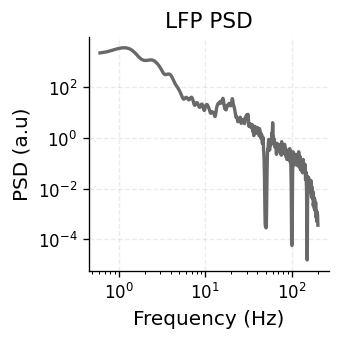

In [6]:
def plot_psd(freqs, psd, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.loglog(freqs, psd, 'dimgray', lw=2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (a.u)")
    plt.title("LFP PSD")
    plt.grid(True, ls="--", alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_psd(freqs, psd)

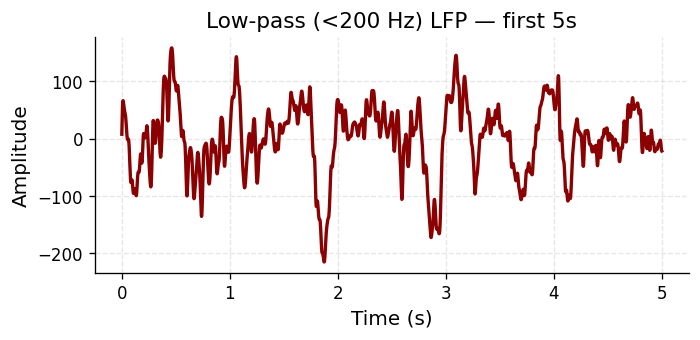

In [7]:
def plot_signal_snippet(t, x, snippet_sec, figsize=(6, 3), color='darkred'):
    plt.figure(figsize=figsize)
    plt.plot(t, x, lw=2.0, color=color)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Low-pass (<200 Hz) LFP — first {snippet_sec:g}s")
    plt.grid(True, ls='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_signal_snippet(time[:N], xs[:N], snippet_sec)

In [ ]:
# Apply envelope normalization
xs, x_bp, A_est = envelope_normalize(xs, Fs, fband=(1, 80), env_lp_hz=3.0)

# Sweep AR orders
def sweep_ar_orders(xs, p_list, train_frac=0.9):
    mse_list, aic_list, bic_list = [], [], []
    params_by_p, splits = {}, {}
    
    for p in p_list:
        X, y = AR.lag_matrix(xs, p)
        ntr = int(train_frac * len(y))
        X_tr, y_tr = X[:ntr], y[:ntr]
        X_te, y_te = X[ntr:], y[ntr:]
        w = AR.fit(X_tr, y_tr)
        yhat_tr = AR.predict_from_params(X_tr, w)
        yhat_te = AR.predict_from_params(X_te, w)
        mse_te, _, _ = AR.metrics(y_te, yhat_te)
        aic, bic = AR.aic_bic(y_tr, yhat_tr, k=p+1)
        mse_list.append(mse_te)
        aic_list.append(aic)
        bic_list.append(bic)
        params_by_p[p] = w
        splits[p] = (ntr, y, yhat_tr, yhat_te)
    
    return mse_list, aic_list, bic_list, params_by_p, splits

p_list = list(range(2, 7))
mse_te_list, aic_list, bic_list, params_by_p, splits = sweep_ar_orders(xs, p_list)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

best_p_by_mse, best_p_by_bic = 4, 4
print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

# Prepare predictions
REFRESH_EVERY = 5
p_use = best_p_by_bic
w = params_by_p[p_use]
X, y = AR.lag_matrix(xs, p_use)
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
N_te = len(y) - ntr
t0 = p_use + ntr
true_test = xs[t0 : t0 + N_te]
yhat_ctrl = AR.hybrid_predict(xs, w, p_use, start_idx=t0, n_steps=N_te, refresh_every=REFRESH_EVERY)

Best p by TEST MSE: p=4, MSE=0.001401
Best p by BIC (training fit): p=4


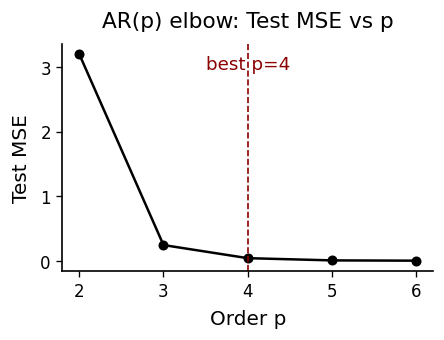

In [11]:
def plot_mse_elbow(p_list, mse_list, best_p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(p_list, mse_list, marker='o', color=color_main, lw=1.5, ms=5)
    ax.axvline(best_p, linestyle='--', color=color_alt, linewidth=1)
    ax.text(best_p, ax.get_ylim()[1]*0.95, f"best p={best_p}", ha='center', va='top', color=color_alt, fontsize=11)
    sf = ScalarFormatter(useMathText=True)
    sf.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(sf)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.get_offset_text().set_size(10)
    prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
    plt.tight_layout()
    plt.show()

plot_mse_elbow(p_list, mse_te_list, best_p_by_mse)

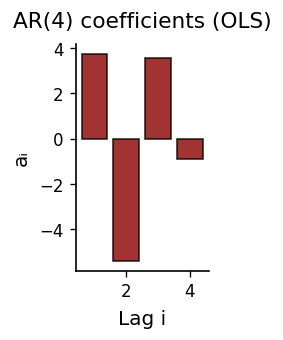

In [12]:
def plot_ar_coefficients(w, p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(2, 3))
    ax.bar(np.arange(1, p+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
    prettify(ax, title=f"AR({p}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
    plt.tight_layout()
    plt.show()

plot_ar_coefficients(w, p_use)

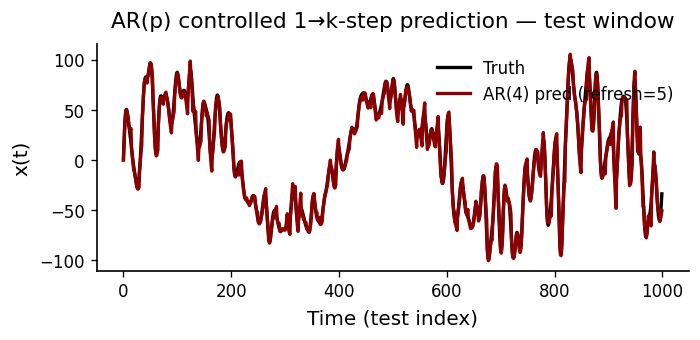

In [13]:
def plot_prediction(y_true, y_pred, p, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(y_true + 1, color=color_main, lw=2, label="Truth")
    ax.plot(y_pred, color=color_alt, lw=2, label=f"AR({p}) pred (refresh={refresh})")
    prettify(ax, title="AR(p) controlled 1→k-step prediction — test window",
             xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
    plt.tight_layout()
    plt.show()

plot_prediction(y[ntr:], yhat_ctrl, p_use, REFRESH_EVERY)

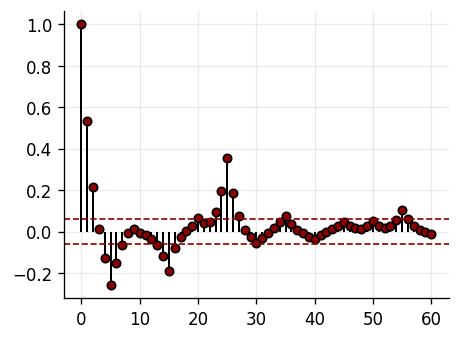

In [14]:
def plot_residual_acf(resid, nlags=60, color_main="black", color_alt="darkred"):
    acf_vals = acf(resid, nlags=nlags)
    bound = 1.96 / np.sqrt(max(len(resid), 1))
    fig, ax = plt.subplots(figsize=(4, 3))
    markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
    plt.setp(stemlines, color=color_main, linewidth=1.2)
    plt.setp(markerline, marker='o', markersize=5, markeredgecolor=color_main, markerfacecolor=color_alt)
    ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
    ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
    plt.tight_layout()
    plt.show()

resid_te = y[ntr:] - yhat_ctrl
plot_residual_acf(resid_te)

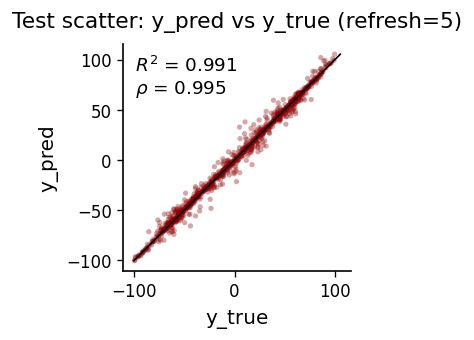

In [15]:
def plot_scatter(y_true, y_pred, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
    vmin, vmax = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))
    ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-12)
    ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
            transform=ax.transAxes, ha='left', va='top', fontsize=11,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
    ax.set_aspect('equal', adjustable='box')
    prettify(ax, title=f"Test scatter: y_pred vs y_true (refresh={refresh})", xlabel="y_true", ylabel="y_pred")
    plt.tight_layout()
    plt.show()

plot_scatter(y[ntr:], yhat_ctrl, REFRESH_EVERY)

In [16]:
def plot_state_space(X3_true, X3_pred, p, tau, refresh, color_true="black", color_pred="darkred"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], label="TRUE", color=color_true, alpha=0.85)
    ax.plot(X3_pred[:,0], X3_pred[:,1], X3_pred[:,2], label=f"AR({p}) hybrid (refresh={refresh})", color=color_pred, alpha=0.85)
    ax.set_title(f"State space — TRUE vs AR hybrid (τ={tau}, refresh_every={refresh})")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t-{tau})")
    ax.set_zlabel(f"x(t-{2*tau})")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()


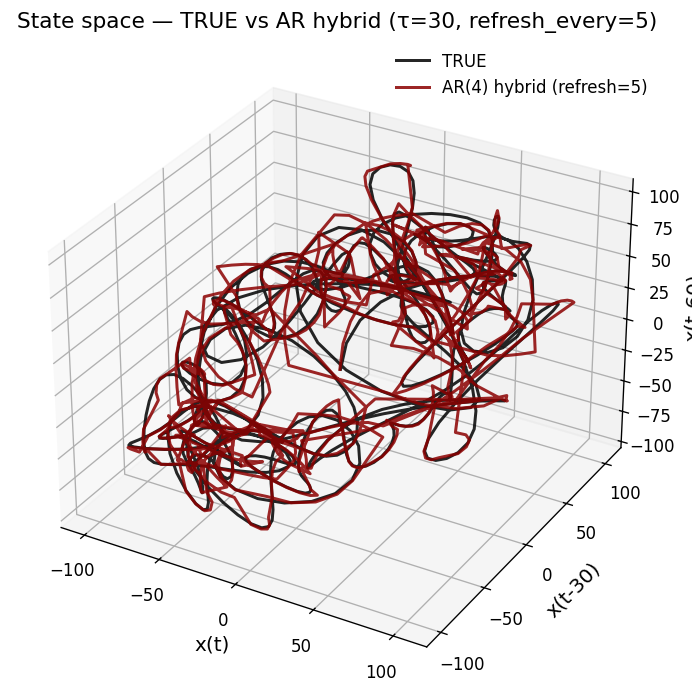

In [17]:
tau = 30
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed(true_test, 3, tau)
X3_hyb = embed(hy, 3, tau)

plot_state_space(X3_true, X3_hyb, p_use, tau, REFRESH_EVERY)

In [64]:
def plot_state_space_windows_comparison(xs, xs_pred, Fs, tau, embed_dim=3, 
                                         windows=[(6, 8), (8, 10), (10, 12), (12, 14)]):
    fig, axes = plt.subplots(1, 4, figsize=(len(windows)*4, 4), subplot_kw={'projection': '3d'})
    
    for ax, (t_start, t_end) in zip(axes, windows):
        idx_start = int(t_start * Fs)
        idx_end = int(t_end * Fs)
        
        # True signal
        segment_true = xs[idx_start:idx_end]
        X3_true = embed(segment_true, embed_dim, tau)
        
        # Predicted signal (variance-matched)
        segment_pred = xs_pred[idx_start:idx_end]
        seg_pred_matched = segment_pred - np.mean(segment_pred)
        seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
        seg_pred_matched = seg_pred_matched + np.mean(segment_true)
        X3_pred = embed(seg_pred_matched, embed_dim, tau)
        
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label='AR(4) pred')
        ax.set_xlabel("x(t)")
        ax.set_ylabel(f"x(t-{tau})")
        ax.set_zlabel(f"x(t-{2*tau})")
        ax.text2D(0.5, -0.2, f"{t_start}-{t_end} s", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    # fig.suptitle(f"State space: TRUE vs AR({p_use}) (τ={tau}, refresh={REFRESH_EVERY})", y=0.02)
    # plt.tight_layout()
    plt.show()

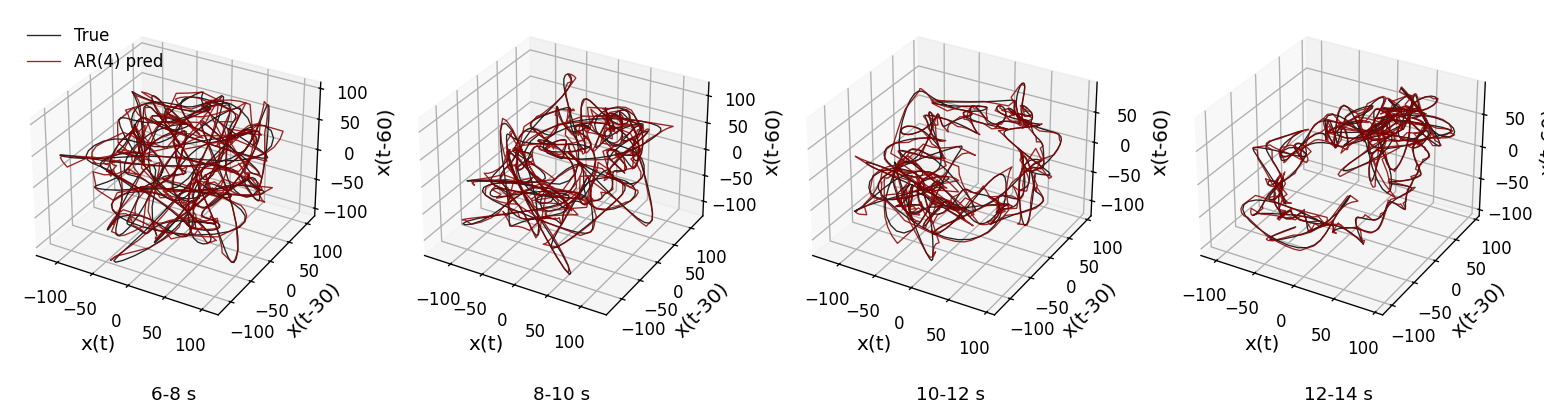

In [65]:
# Build full prediction for visualization
full_pred = AR.hybrid_predict(xs, w, p_use, start_idx=p_use, n_steps=len(xs)-p_use, refresh_every=REFRESH_EVERY)
xs_pred_full = np.concatenate([xs[:p_use], full_pred])

plot_state_space_windows_comparison(xs, xs_pred_full, Fs, tau)

In [66]:
def plot_state_space_tau_sweep(xs, xs_pred, Fs, t_start, t_end, taus=[3, 30, 60, 90], embed_dim=3):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), subplot_kw={'projection': '3d'})
    
    idx_start = int(t_start * Fs)
    idx_end = int(t_end * Fs)
    segment_true = xs[idx_start:idx_end]
    segment_pred = xs_pred[idx_start:idx_end]
    
    # Variance-match prediction
    seg_pred_matched = segment_pred - np.mean(segment_pred)
    seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
    seg_pred_matched = seg_pred_matched + np.mean(segment_true)
    segment_pred
    for ax, tau_val in zip(axes, taus):
        X3_true = embed(segment_true, embed_dim, tau_val)
        X3_pred = embed(seg_pred_matched, embed_dim, tau_val)
        
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label='AR(4) pred')
        ax.set_xlabel("x(t)")
        ax.set_ylabel(f"x(t-{tau_val})")
        ax.set_zlabel(f"x(t-{2*tau_val})")
        ax.text2D(0.5, -0.2, f"τ = {tau_val}", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    plt.show()

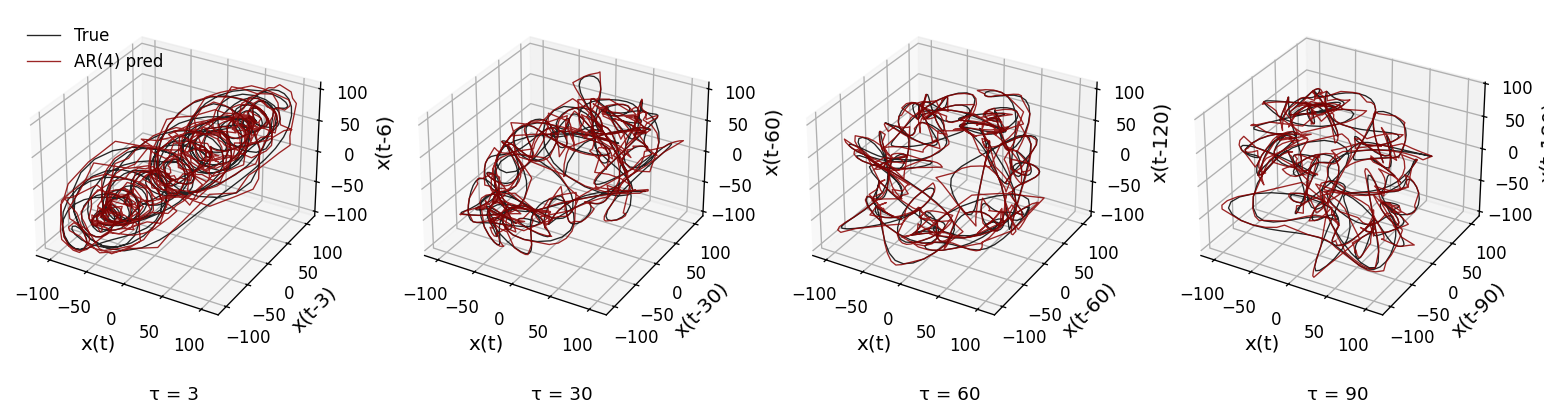

In [67]:
plot_state_space_tau_sweep(xs, xs_pred_full, Fs, t_start=18, t_end=20)